In [57]:
from datetime import datetime
import sys
import time
from SPARQLWrapper import SPARQLWrapper, JSON
import requests
from PIL import Image
import html

endpoint_url = "https://computational-publishing-service.wikibase.cloud/query/sparql"

query_txt = """PREFIX cps: <https://computational-publishing-service.wikibase.cloud/entity/>
PREFIX cpss: <https://computational-publishing-service.wikibase.cloud/entity/statement/>
PREFIX cpsv: <https://computational-publishing-service.wikibase.cloud/value/>
PREFIX cpspt: <https://computational-publishing-service.wikibase.cloud/prop/direct/>
PREFIX cpsp: <https://computational-publishing-service.wikibase.cloud/prop/>
PREFIX cpsps: <https://computational-publishing-service.wikibase.cloud/prop/statement/>
PREFIX cpspq: <https://computational-publishing-service.wikibase.cloud/prop/qualifier/>

SELECT ?textItem ?kuratorLabel ?textUrl
WHERE
{
  <placeholder>
  ?textItem cpsp:P46 ?kuratorStatement. 
  ?kuratorStatement cpsps:P46 ?kuratorItem. 
  ?kuratorItem rdfs:label ?kuratorLabel.
  ?textItem cpsp:P57 ?urlstatement. 
  ?urlstatement cpsps:P57 ?textUrl. 
}"""

query_img = """PREFIX cps: <https://computational-publishing-service.wikibase.cloud/entity/>
PREFIX cpss: <https://computational-publishing-service.wikibase.cloud/entity/statement/>
PREFIX cpsv: <https://computational-publishing-service.wikibase.cloud/value/>
PREFIX cpspt: <https://computational-publishing-service.wikibase.cloud/prop/direct/>
PREFIX cpsp: <https://computational-publishing-service.wikibase.cloud/prop/>
PREFIX cpsps: <https://computational-publishing-service.wikibase.cloud/prop/statement/>
PREFIX cpspq: <https://computational-publishing-service.wikibase.cloud/prop/qualifier/>

SELECT DISTINCT ?itemLabel ?itemDescr ?imgItem ?imgUrl ?publishDate 
WHERE
{
  ?imgItem cpsp:P107 ?urlStatement. 
  ?urlStatement cpsps:P107 ?imgUrl. 
  ?imgItem cpsp:P60 ?dateStatement. 
  ?dateStatement cpsps:P60 ?publishDate.
  ?imgItem cpsp:P6 ?partOfStatement.
  ?partOfStatement cpsps:P6 ?partOfItem.
  <placeholder> 
  SERVICE wikibase:label {
      bd:serviceParam wikibase:language "de,en".
      ?imgItem rdfs:label ?itemLabel.
      ?imgItem schema:description ?itemDescr.
    }
}"""
query_graph = """PREFIX cps: <https://computational-publishing-service.wikibase.cloud/entity/>
PREFIX cpss: <https://computational-publishing-service.wikibase.cloud/entity/statement/>
PREFIX cpsv: <https://computational-publishing-service.wikibase.cloud/value/>
PREFIX cpspt: <https://computational-publishing-service.wikibase.cloud/prop/direct/>
PREFIX cpsp: <https://computational-publishing-service.wikibase.cloud/prop/>
PREFIX cpsps: <https://computational-publishing-service.wikibase.cloud/prop/statement/>
PREFIX cpspq: <https://computational-publishing-service.wikibase.cloud/prop/qualifier/>

SELECT ?x ?y
WHERE
{
  ?a cpsp:P2 ?c.
  ?c cpsps:P2 ?d.
  ?a rdfs:label ?x.
  ?d rdfs:label ?y.

}LIMIT 1"""

query_graph2 = """
SELECT ?a ?b ?c
WHERE
{
  ?a rdfs:label ?c
}LIMIT 100"""


def run_query(endpoint_url, query):
    user_agent = "WDQS-example Python/%s.%s" % (sys.version_info[0], sys.version_info[1])
    # TODO adjust user agent; see https://w.wiki/CX6
    sparql = SPARQLWrapper(endpoint_url, agent=user_agent)
    sparql.setQuery(query)
    sparql.setMethod("POST") #this NEEDS to be added to get results (not included in the wikibase python example code)
    sparql.setReturnFormat(JSON)
    return sparql.query().convert()

def get_text(textitem_id):
    q = ""
    if textitem_id:
        q = query_txt.replace("<placeholder>", "cps:"+textitem_id+" cpsp:P46 ?kuratorStatement.")
    else:
        q = query_txt.replace("<placeholder>","")

    results_txt = run_query(endpoint_url, q)
    for item in results_txt["results"]["bindings"]:
        print('Wikibase link: ' + '[' + item['textItem']['value'] + ']' + '(' + item['textItem']['value'] + ')' + '\n')
        print('Kurator: ' + item['kuratorLabel']['value'] + '\n')
        headers = {'User-Agent': 'Ex_Books_conference_bot/0.0 (https://github.com/SimonXIX/Experimental_Books_workshop; ad7588@coventry.ac.uk)'}
        r = requests.get(item['textUrl']['value'], headers=headers, stream=True)
        text = str(r.text) #changed from r.content
        text = text.replace("ä","&auml;") 
        text = text.replace("Ä","&Auml;")
        text = text.replace("ö","&ouml;")
        text = text.replace("Ö","&Ouml;")
        text = text.replace("ü","&uuml;")
        text = text.replace("Ü","&Uuml;")
        text = text.replace("ß","&szlig;")
        text = text.replace('\\n',"<br>")
        text = str(text)
        text = text.removeprefix("<!DOCTYPE html>").removesuffix("'") #changed from b'<!DOCTYPE html>"
        print(text)

def get_delay(date):
    try:
        date = datetime.datetime.strptime(date, '%a, %d %b %Y %H:%M:%S GMT')
        timeout = int((date - datetime.datetime.now()).total_seconds())
    except ValueError:
        timeout = int(date)
    return timeout

def fetch_image_by_url(url, headers):
    r = requests.get(url, headers=headers, stream=True)
    if r.status_code == 200:
        im = Image.open(r.raw)
        return im
    if r.status_code == 500:
        return None
    if r.status_code == 403:
        return None
    if r.status_code == 429:
        timeout = get_delay(r.headers['retry-after'])
        print('Timeout {} m {} s'.format(timeout // 60, timeout % 60))
        time.sleep(timeout)
        fetch_image_by_url(url, headers)

def get_img(partOfItem_id):
    q = ""
    if partOfItem_id:
        q = query_img.replace("<placeholder>", "?partOfStatement cpsps:P6 cps:"+partOfItem_id+".")
    else:
        q = query_img.replace("<placeholder>","")
    results_img = run_query(endpoint_url, q)
    for item in results_img["results"]["bindings"]:    
      #print(item)
      print('Wikibase link: ' + '[' + item['imgItem']['value'] + ']' + '(' + item['imgItem']['value'] + ')' + '\n')
      print('Title: ' + item['itemLabel']['value'] + '\n')
      print('Year: ' + item['publishDate']['value'] + '\n')
      print('Description: ' + html.unescape(item['itemDescr']['value']) + '\n')

      # get image from image URL and display resized version
      image_url=item['imgUrl']['value']
      headers = {'User-Agent': 'Ex_Books_conference_bot/0.0 (https://github.com/SimonXIX/Experimental_Books_workshop; ad7588@coventry.ac.uk)'}
      im = fetch_image_by_url(image_url, headers)
      im.thumbnail((500, 500), Image.Resampling.LANCZOS)
      display(im)
      print('\n\n')

def get_graph():
    import VizKG.visualize as vkg
    results_graph1 = run_query(endpoint_url, query_graph)
    #print(results_graph1)
    #print('---')
    results_graph2 = run_query(endpoint_url, query_graph2)
    #print(results_graph2)

    chart = vkg(sparql_query=query_graph2, sparql_service_url=endpoint_url, chart='wordcloud')
    chart.plot()


In [58]:
get_text("Q232")

Wikibase link: [https://computational-publishing-service.wikibase.cloud/entity/Q232](https://computational-publishing-service.wikibase.cloud/entity/Q232)

Kurator: Seeger, Ulrike


<head>
  <meta charset="utf-8" />
  <meta content="text" />
  <meta name="viewport" content="width=device-width, initial-scale=1.0" />
</head>
<html xmlns="http://www.w3.org/1999/xhtml" lang="de" xml:lang="de">
  <body>
    <h1>Die Tafelstube</h1>
    <h2>Beschreibung</h2>
    <p>
      &Ouml;stlich an den Rittersaal schlie&szlig;t ein gro&szlig;er, 1837 unterteilter Raum an, bei dem es sich um die einstige Tafelstube handelt.[1] Als Eckraum mit vier Doppelfenstern zur Gartenseite und weiteren drei Doppelfenstern zur Grabenseite erhielt die Tafelstube viel Licht. Auch konnte der F&uuml;rst von dort aus auf die Stadt und den Lustgarten blicken, der in der Renaissance dem Schloss s&uuml;d&ouml;stlich vorgelagert war.[2] Gemessen an der Gr&ouml;&szlig;e des Raumes war die Tafelstube nicht sehr hoch. Die Decke m

<hr>

Wikibase link: [https://computational-publishing-service.wikibase.cloud/entity/Q283](https://computational-publishing-service.wikibase.cloud/entity/Q283)

Title: Die barocken Schloss- und Gartenveduten bild

Year: 2018

Description: Bild für Die barocken Schloss- und Gartenveduten



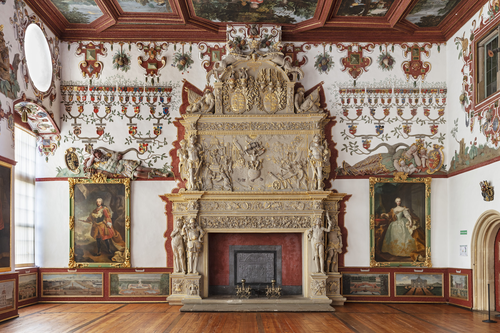




Wikibase link: [https://computational-publishing-service.wikibase.cloud/entity/Q283](https://computational-publishing-service.wikibase.cloud/entity/Q283)

Title: Die barocken Schloss- und Gartenveduten bild

Year: 2018-01-01T00:00:00Z

Description: Bild für Die barocken Schloss- und Gartenveduten



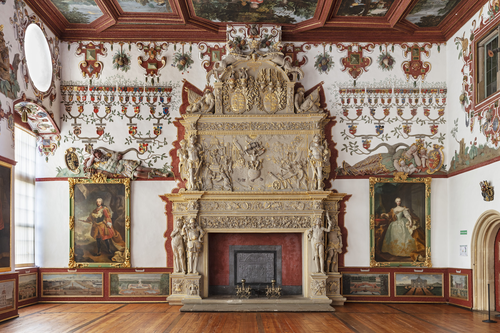

In [59]:
get_img("Q208")

<hr>

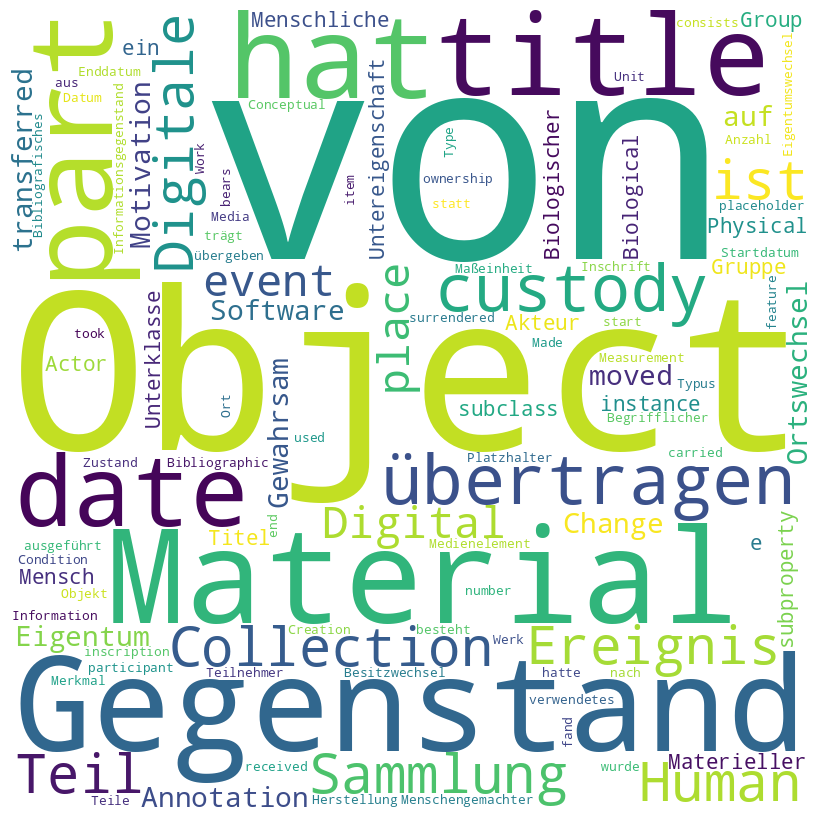

In [60]:
get_graph()